In [1]:
import tqdm
import itertools
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'svg'


from own_tree import UniversalTreeRegressor
from own_forest import RandomForestMSE
from metric import special_func

In [2]:
def save_obj(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def load_obj(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [3]:
def get_X_y(name):
    df = pd.read_csv(name)
    y = np.array(df['target'], dtype=float)
    X = np.array(df.drop(columns=['target', 'compound']), dtype=float)
    return X, y, df

In [4]:
X, y, df = get_X_y('task1.csv')
X.shape

(451, 98)

### Разбиваем на трейн/тест

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Подбираем гиперпараметры случайного леса на кросс-валидации

In [ ]:
params_random_forest = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300, 500, 1000],
    'max_depth': [5, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 3, 5, 7]
}
greedy_random_forest = GridSearchCV(RandomForestRegressor(), params_random_forest, scoring='neg_mean_squared_error', n_jobs=-1)
greedy_random_forest.fit(X_train, y_train)

In [40]:
greedy_random_forest.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}

In [41]:
np.sqrt(-greedy_random_forest.best_score_)

73.6347495486384

In [6]:
random_forest = RandomForestRegressor(max_depth=15, min_samples_split=2, n_estimators=50, random_state=666)
random_forest.fit(X_train, y_train)
y_random_forest_train = random_forest.predict(X_train)
y_random_forest = random_forest.predict(X_test)
print('Train:', mean_squared_error(y_train, y_random_forest_train, squared=False))
print('Test :', mean_squared_error(y_test, y_random_forest, squared=False))

Train: 32.415869494776636
Test : 59.733505157116355


### Подбираем гиперпараметры градиентного бустинга на кросс-валидации

In [33]:
params_boosting = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300, 500],
    'max_depth': [3, 4, 5, 7, 10],
    'min_samples_split': [2, 5, 8, 10]
}
greedy_boosting = GridSearchCV(GradientBoostingRegressor(), params_boosting, scoring='neg_mean_squared_error', n_jobs=-1)
greedy_boosting.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7, 10],
                         'min_samples_split': [2, 5, 8, 10],
                         'n_estimators': [10, 50, 100, 150, 200, 250, 300,
                                          500]},
             scoring='neg_mean_squared_error')

In [42]:
greedy_boosting.best_params_

{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 150}

In [43]:
np.sqrt(-greedy_boosting.best_score_)

66.54794933724155

In [7]:
boosting = GradientBoostingRegressor(max_depth=3, min_samples_split=10, n_estimators=150, random_state=666)
boosting.fit(X_train, y_train)
y_boosting_train = boosting.predict(X_train)
y_boosting = boosting.predict(X_test)
print('Train:', mean_squared_error(y_train, y_boosting_train, squared=False))
print('Test :', mean_squared_error(y_test, y_boosting, squared=False))

Train: 33.07752517350794
Test : 65.11881704436809


### Создаем данные для обучения специального дерева

In [8]:
coefs = np.array([0.95, 0.1, -0.05], dtype=float)
G = np.array(np.hstack([
    y_train[:, None],
    y_boosting_train[:, None],
    y_random_forest_train[:, None]
]))
G_test = np.array(np.hstack([
    y_test[:, None],
    y_boosting[:, None],
    y_random_forest[:, None]
]))

In [10]:
G_def = np.zeros_like(G)
G_def[:, 0] = y_train
coefs_def = np.array([1.0, 0, 0], dtype=float)

### Перебираем гиперпараметры дерева

In [12]:
params = {
    'max_depth': [3, 4, 5, 7, 8, 9, 10, 12, 20],
    'min_samples_split': [2, 3, 5, 10],
    'gamma_1': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'mu': [0.0, 0.2, 0.4, 0.6, 0.8]
}
tree_names = set(['max_depth', 'min_samples_split'])

In [13]:
names = []
vals = []
for param_name, param_vals in params.items():
    names.append(param_name)
    vals.append(param_vals)

total = 1
for v in vals:
    total *= len(v)
    
ranges = [range(len(v)) for v in vals]

stats = []

for idxs in tqdm.tqdm(itertools.product(*ranges), total=total):
    cur_tree_params = {name: val[idx] for name, val, idx in zip(names, vals, idxs) if name in tree_names}
    cur_coefs_params = {name: val[idx] for name, val, idx in zip(names, vals, idxs) if name not in tree_names}
    
    tree = UniversalTreeRegressor(**cur_tree_params)
    
    coefs[0] = cur_coefs_params['gamma_1']
    coefs[1] = 1.0 - coefs[0]
    coefs[2] = -cur_coefs_params['mu']
    
    if coefs.sum() <= 0:
        continue
    
    tree.fit(X_train, G, coefs)
    
    stats.append(
        [val[idx] for val, idx in zip(vals, idxs)] + [
            special_func(G, coefs, tree.predict(X_train)),
            special_func(G_test, coefs, tree.predict(X_test))
        ]
    )

df = pd.DataFrame(data=stats, columns=names + ['Train', 'Test'])
df

100%|███████████████████████████████████████| 1080/1080 [03:25<00:00,  5.25it/s]


,max_depth,min_samples_split,gamma_1,mu,Train,Test
0,3,2,0.0,0.0,5409.539196,5944.672875
1,3,2,0.0,0.2,4417.529565,5519.871872
2,3,2,0.0,0.4,3405.087873,4577.368641
3,3,2,0.0,0.6,2388.717093,3626.659467
4,3,2,0.0,0.8,1240.316657,1141.764814
...,...,...,...,...,...,...
1075,20,10,1.0,0.0,2074.808110,6299.263473
1076,20,10,1.0,0.2,1584.598292,5941.838692
1077,20,10,1.0,0.4,1358.302131,6531.905112
1078,20,10,1.0,0.6,857.303302,7772.513355


In [14]:
df.to_csv('results_task_1_train_test_split_7_to_3_random_state_666.csv')

In [9]:
df = pd.read_csv('results_task_1_train_test_split_7_to_3_random_state_666.csv')

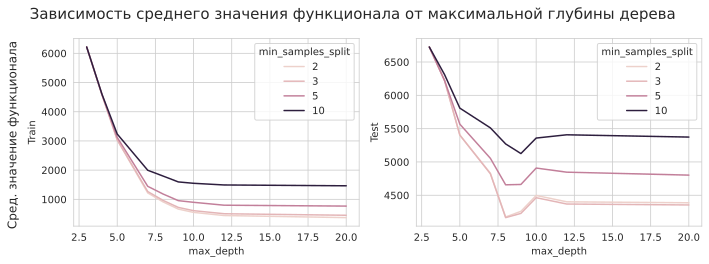

In [13]:
df_temp = df[(df['gamma_1'] == 0.8) & (df['mu'] == 0.2)]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.7))
sns.lineplot(df_temp, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('Зависимость среднего значения функционала от максимальной глубины дерева', fontsize=15)
fig.supylabel('Сред. значение функционала')
fig.tight_layout()
fig.savefig('data/max_depth_task1_gamma_08_mu_02.pdf')
plt.show()

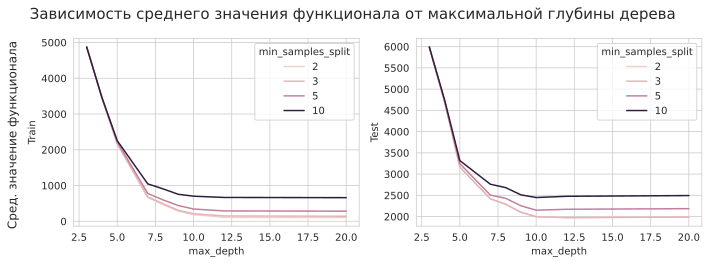

In [52]:
df_temp = df[(df['gamma_1'] == 0.2) & (df['mu'] == 0.2)]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.7))
sns.lineplot(df_temp, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('Зависимость среднего значения функционала от максимальной глубины дерева', fontsize=15)
fig.supylabel('Сред. значение функционала')
fig.tight_layout()
fig.savefig('data/max_depth_task1_gamma_02_mu_02.pdf')
plt.show()

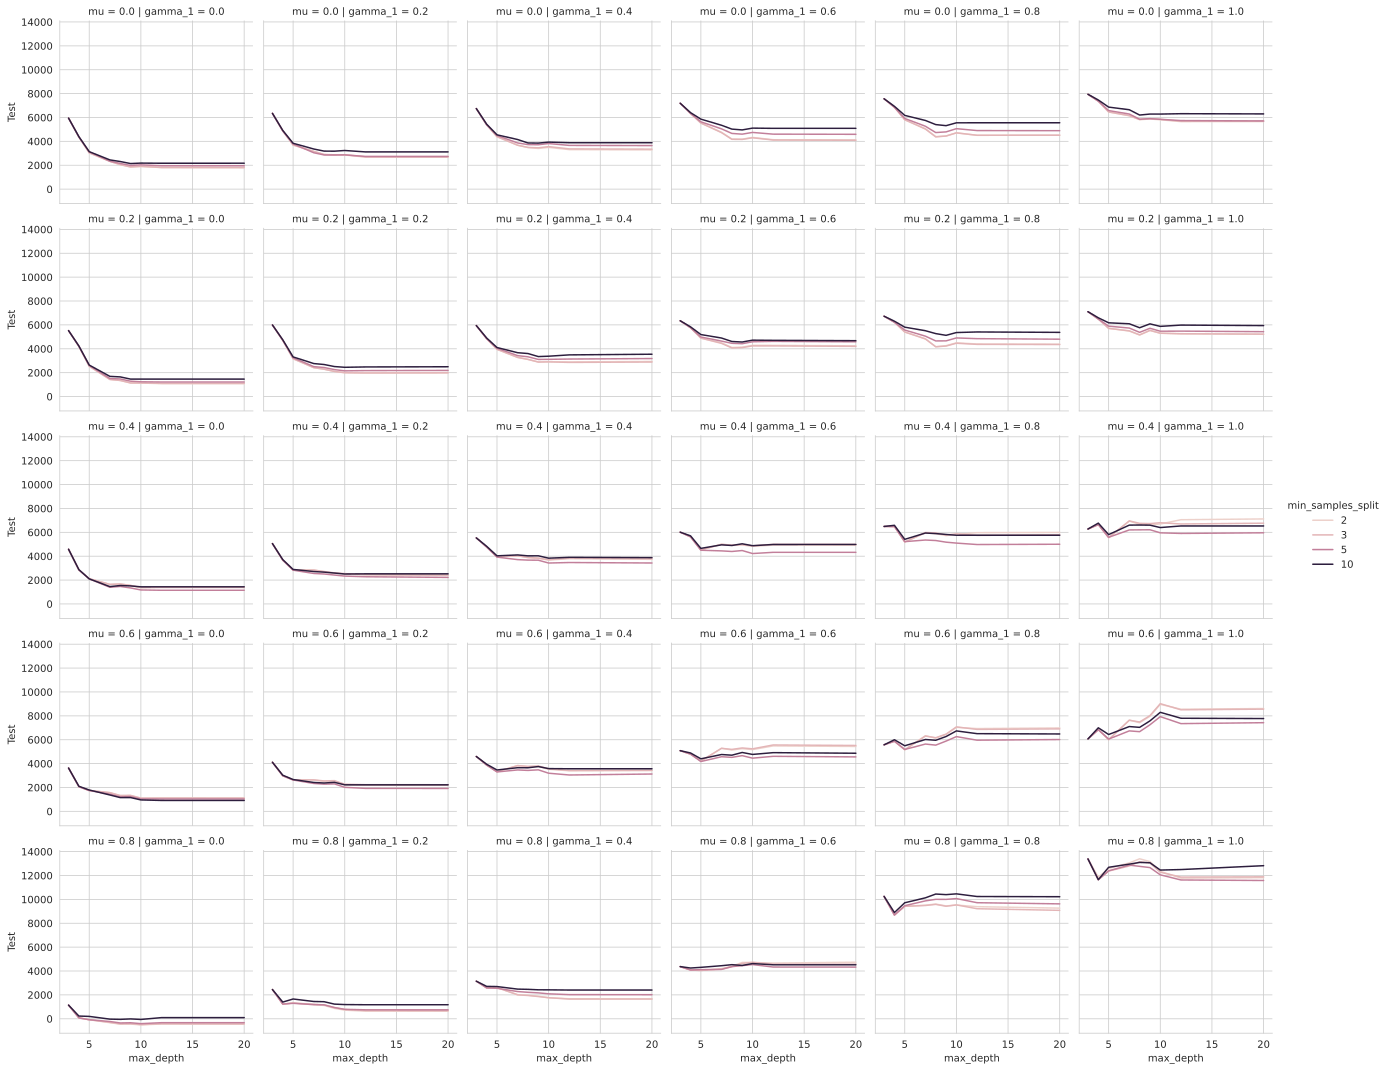

In [16]:
sns.relplot(df, x='max_depth', y='Test', row='mu', col='gamma_1', kind='line', hue='min_samples_split', height=3)

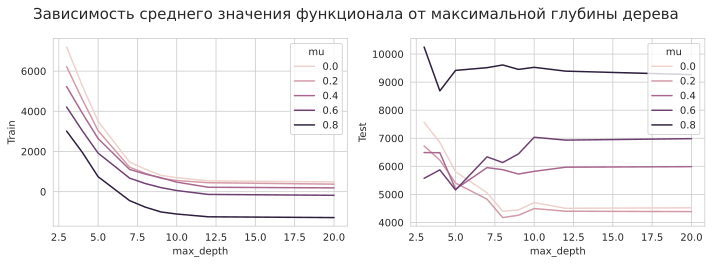

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.7))
df_temp = df[(df['gamma_1'] == 0.8) & (df['min_samples_split'] == 2)]
sns.lineplot(df_temp, x='max_depth', y='Train', hue='mu', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='mu', ax=axes[1])
fig.suptitle('Зависимость среднего значения функционала от максимальной глубины дерева', fontsize=15)
fig.tight_layout()
fig.savefig('data/max_depth_task1_gamma_08_min_2.pdf', bbox_inches='tight')
plt.show()

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from itertools import product

param_grid = {
    'max_depth': [3, 4, 5, 7, 8, 9, 10, 12, 20],
    'min_samples_split': [2, 3, 5, 10]
}

names = list(param_grid)
values = [param_grid[n] for n in names]

stats = []

for vals in product(*values):
    params = {n: p for n, p in zip(names, vals)}
    tree = DecisionTreeRegressor(**params)
    tree.fit(X_train, y_train)
    mse_train = mean_squared_error(y_train, tree.predict(X_train))
    mse_test = mean_squared_error(y_test, tree.predict(X_test))
    stats.append([*vals, mse_train, mse_test])

df = pd.DataFrame(stats, columns=[*names, 'Train', 'Test'])

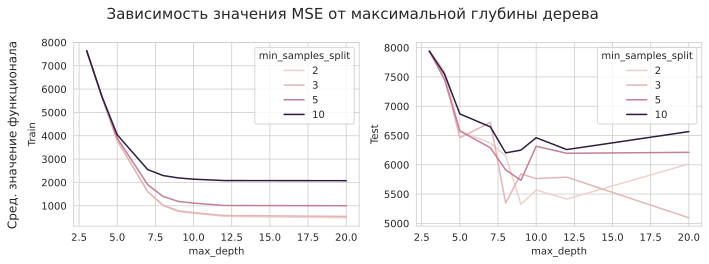

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.7))
sns.lineplot(df, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('Зависимость значения MSE от максимальной глубины дерева', fontsize=15)
fig.supylabel('Сред. значение функционала')
fig.tight_layout()
fig.savefig('data/task1_common_mse.pdf', bbox_inches='tight')
plt.show()